<a href="https://colab.research.google.com/github/Liza23/Seasons-of-Code_Why-Hype-Around-GAN-s/blob/master/GAN%7CKeras%7CMNSIT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Packages and Image load

In [3]:
from keras.datasets import mnist
from keras.utils import np_utils
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Activation, Flatten, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose, UpSampling2D, Convolution2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import notebook

Using TensorFlow backend.


In [0]:
(X_train,Y_train),(X_test,Y_test)=mnist.load_data()

In [5]:
print("X_train:",X_train.shape)
print("X_test:",X_test.shape)

X_train: (60000, 28, 28)
X_test: (10000, 28, 28)


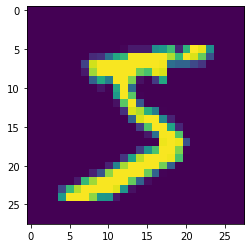

In [6]:
plt.imshow(X_train[0])
plt.show()

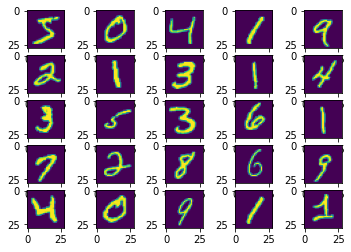

In [7]:
for i in range(25):
	plt.subplot(5, 5, 1 + i)
	plt.imshow(X_train[i])
plt.show()

### Image Preprocessing

In [0]:
X_train=np.reshape(X_train,(60000,28,28,1))
X_test=np.reshape(X_test,(10000,28,28,1))

In [9]:
print("X_train:",X_train.shape)
print("X_test:",X_test.shape)

X_train: (60000, 28, 28, 1)
X_test: (10000, 28, 28, 1)


In [11]:
X_train = X_train[0:10000]
print("X_train:",X_train.shape)

X_train: (10000, 28, 28, 1)


In [0]:
X_train = X_train.astype('float32')/255
X_test = X_test.astype('float32')/255

In [0]:
noise_dim=100

# Generator Function

In [0]:
def generator():
  g_input=Input(shape=(noise_dim,))
  G=Dense(units=784)(g_input)
  G=LeakyReLU(0.2)(G)

  G=Reshape((28,28,1))(G)
  G=Convolution2D(64,(3,3))(G)
  G=LeakyReLU(0.2)(G)
  G=Flatten()(G)

  G=Dense(units=512)(G)
  G=LeakyReLU(0.2)(G)

  G=Dense(units=1024)(G)
  G=LeakyReLU(0.2)(G)

  G=Dense(units=784, activation='tanh')(G) 
  g_output=Reshape((28,28,1), name='out_layer')(G)
      
  generator=Model(inputs=g_input, outputs=g_output)
  generator.compile(loss='binary_crossentropy', optimizer=Adam
                    (learning_rate=0.001), metrics=['accuracy'])
  return generator

In [15]:
generator=generator()
generator.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 784)               79184     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 784)               0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 64)        640       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 26, 26, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 43264)             0   

# Discriminator Function

In [0]:
def discriminator():
  d_input=Input(shape=(28*28*1,))

  D=Dense(units=1024)(d_input)
  D=LeakyReLU(0.2)(D)

  D=Dense(units=512)(D)
  D=LeakyReLU(0.2)(D)

  D=Dense(units=256)(D)
  D=LeakyReLU(0.2)(D)

  d_output=Dense(units=1, activation='sigmoid')(D)

  discriminator=Model(inputs=d_input, outputs=d_output)
  discriminator.compile(loss='binary_crossentropy', optimizer=Adam
                        (learning_rate=0.001),metrics=['accuracy'])
  return discriminator

In [17]:
discriminator=discriminator()
discriminator.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1024)              803840    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               524800    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 256)               0   

# GAN Function

In [0]:
def gan(generator,discrminator):
  discriminator.trainable=False
  
  inputs=Input(shape=(noise_dim,))
  hidden=generator(inputs)
  hidden=Flatten()(hidden)
  outputs=discriminator(hidden)
  
  gan=Model(inputs,outputs)
  gan.compile(loss='binary_crossentropy', optimizer=Adam
              (learning_rate=0.001),metrics=['accuracy'])
  
  return gan

In [19]:
gan=gan(generator,discriminator)
gan.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 100)               0         
_________________________________________________________________
model_1 (Model)              (None, 28, 28, 1)         23560416  
_________________________________________________________________
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
model_2 (Model)              (None, 1)                 1460225   
Total params: 25,020,641
Trainable params: 23,560,416
Non-trainable params: 1,460,225
_________________________________________________________________


# Plotting Losses and Generated Images

In [0]:
def plot_loss(losses):
    d_loss = [v[0] for v in losses["D"]]
    g_loss = [v[0] for v in losses["G"]]
    
    plt.figure(figsize=(10,8))
    plt.plot(d_loss, label="Discriminator loss")
    plt.plot(g_loss, label="Generator loss")

    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [0]:
def plot_generated(n_ex=10, dim=(1, 10), figsize=(12, 2)):
    noise = np.random.normal(0, 1, size=(n_ex, noise_dim))
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(generated_images.shape[0], 28, 28)
    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i, :, :], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Training Model

In [0]:
# Set up a vector (dict) to store the losses
losses = {"D":[], "G":[]}
samples = []

In [0]:
def train(epochs=1, plt_frq=1, BATCH_SIZE=28):
    batchCount = int(X_train.shape[0] / BATCH_SIZE)
    print('Epochs:', epochs)
    print('Batch size:', BATCH_SIZE)
    print('Batches per epoch:', batchCount)
    
    for e in notebook.tqdm(range(1, epochs+1)):
        if e == 1 or e%plt_frq == 0:
            print('-'*15, 'Epoch %d' % e, '-'*15)
        for _ in range(batchCount):  # notebook.tqdm(range(batchCount), leave=False):
            # Create a batch by drawing random index numbers from the training set
            image_batch = X_train[np.random.randint(0, X_train.shape[0], size=BATCH_SIZE)]
            image_batch = image_batch.reshape(image_batch.shape[0], image_batch.shape[1], image_batch.shape[2], 1)
            # Create noise vectors for the generator
            noise = np.random.normal(0, 1, size=(BATCH_SIZE, noise_dim))
            
            # Generate the images from the noise
            generated_images = generator.predict(noise)
            samples.append(generated_images)
            X = np.concatenate((image_batch, generated_images))
            X=np.reshape(X,(-1,28*28*1))
            # Create labels
            y = np.zeros(2*BATCH_SIZE)
            y[:BATCH_SIZE] = 0.9  # One-sided label smoothing

            # Train discriminator on generated images
            discriminator.trainable = True
            d_loss = discriminator.train_on_batch(X, y)

            # Train generator
            noise = np.random.normal(0, 1, size=(BATCH_SIZE, noise_dim))
            y2 = np.ones(BATCH_SIZE)
            discriminator.trainable = False
            g_loss = gan.train_on_batch(noise, y2)

        # Only store losses from final batch of epoch
        losses["D"].append(d_loss)
        losses["G"].append(g_loss)

        # Update the plots
        if e == 1 or e%plt_frq == 0:
            plot_generated()
    plot_loss(losses)

Epochs: 100
Batch size: 32
Batches per epoch: 312


--------------- Epoch 1 ---------------


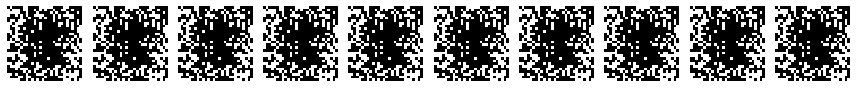

--------------- Epoch 10 ---------------


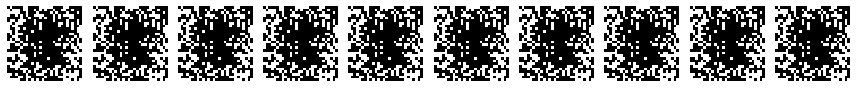

--------------- Epoch 20 ---------------


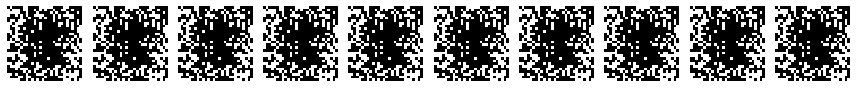

--------------- Epoch 30 ---------------


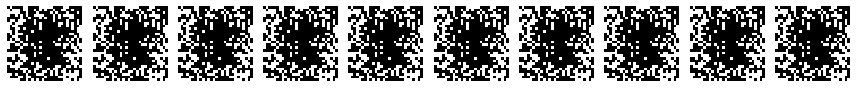

--------------- Epoch 40 ---------------


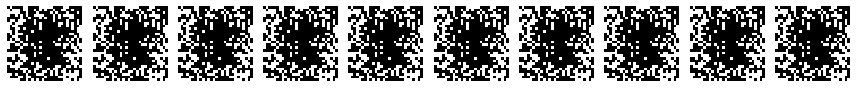

--------------- Epoch 50 ---------------


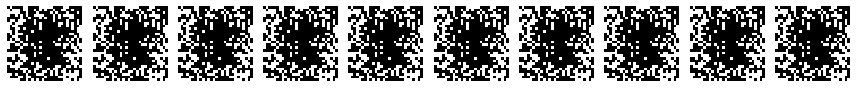

--------------- Epoch 60 ---------------


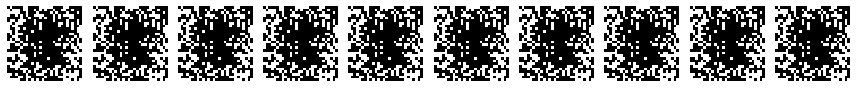

--------------- Epoch 70 ---------------


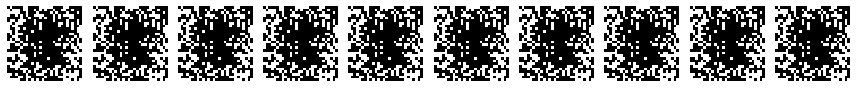

--------------- Epoch 80 ---------------


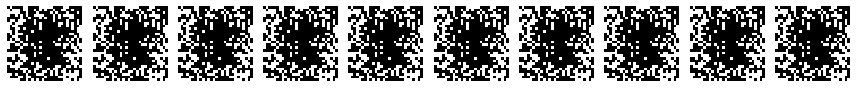

--------------- Epoch 90 ---------------


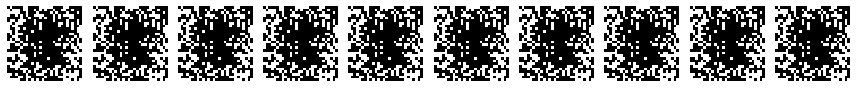

--------------- Epoch 100 ---------------


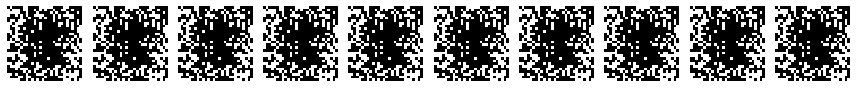

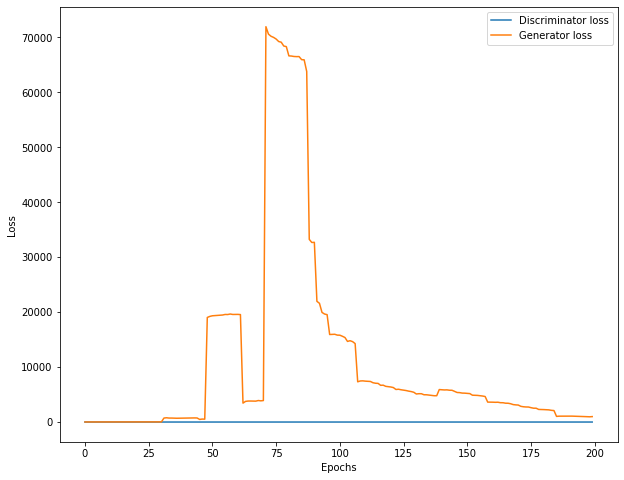

In [25]:
train(epochs=100, plt_frq=10, BATCH_SIZE=32)